Author: Diego Ruiz \
Affiliation: Alice&Bob - INRIA \
Date: 2023

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import ipywidgets as widgets
from IPython.display import clear_output

# fetch data

In [2]:
result_data = []

# read the code parameters from Calculate_code_parameters.cpp
def read_result(filename,result):
    with open(filename, 'r') as file:
        while True:
            # Read stabilizer
            stab = []
            while True:
                line = file.readline().strip()
                if line == '---':
                    break
                if not line:
                    return
                stab.append(list(map(int, line.split())))
            stab = np.array(stab)
                        
            # Read k, d, and gain = kd/n
            k = int(file.readline().strip())
            d = int(file.readline().strip())
            gain = float(file.readline().strip())
            
            # add code parameters in result list
            result.append([])
            result[-1].append(stab) # stabilizer
            result[-1].append(k) # number of logical qubits
            result[-1].append(d) # distance of the code
            result[-1].append(gain) # kd/n
            result[-1].append(np.sum(stab)) # stabilizer weight
            
            # determine if the code is a cellular automaton
            IsCellular = False
            if np.sum(stab[0]) == 1:
                IsCellular = True
            if np.sum(stab[1]) == 1 and (np.sum(stab[2]) == 0 or np.sum(stab[0]) == 0):
                IsCellular = True
            if np.sum(stab[2]) == 1:
                IsCellular = True
                
            result[-1].append(IsCellular)
            
            # determine if the stabilizer spans 3 rows
            FirstLineEmpty = (np.sum(stab[0]) == 0)
            SecondLineEmpty = (np.sum(stab[1]) == 0)
            ThirdLineEmpty = (np.sum(stab[2]) == 0)
            IsOn3Lines = (not FirstLineEmpty) and (not SecondLineEmpty) and (not ThirdLineEmpty)
            
            result[-1].append(IsOn3Lines)
    
for i in range(3,18):
    for j in range(3,18):
        read_result('./result/result'+str(i)+'_'+str(j)+'.txt',result_data)
        
print("data loaded")

data loaded


# color bar

In [3]:
# colors for stabilizer weight
rgcolor = ['#1398c4', '#ff6b6b', '#34C9A4', '#ffc463', '#92A5B5', '#BA55D3', '#c0675c', '#FF7F24']

# add a pastel style to color
def pastel(hex_color):
    # Remove the '#' from the start if it's there
    hex_color = hex_color.lstrip('#')
    
    # Split the string into red, green, and blue components and convert to integers
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    
    # Blend each RGB component with white
    blending_factor = 0.40
    r_pastel = int(r + (255 - r) * blending_factor)
    g_pastel = int(g + (255 - g) * blending_factor)
    b_pastel = int(b + (255 - b) * blending_factor)
        
    # Convert each RGB component to its hexadecimal representation and concatenate
    hex_color = "#{:02x}{:02x}{:02x}".format(r_pastel, g_pastel, b_pastel)
    return hex_color

# add pastel style to color
rgpastel = []
for i in range(len(rgcolor)):
    rgpastel.append(pastel(rgcolor[i]))
        
# Create the colormap
boundaries = list(range(2, 11))
midpoints = [(boundaries[i] + boundaries[i+1]) / 2 for i in range(len(boundaries)-1)]
cmap = mcolors.ListedColormap(rgpastel)
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

# Add best codes in a dictionary

In [4]:
# Dictionary to store (d, gain) as keys and (weight, IsCellular) as values.
Unique_codes = {}

# Iterate over all the codes
for i in range(len(result_data)):
    # fetch parameters of the code
    d, gain, w, IsCellular,IsOn3Lines = result_data[i][2], result_data[i][3], result_data[i][4], result_data[i][5], result_data[i][6]
    
    ShouldAddCode = True
    keys_to_remove = []
       
    ## compare to codes with the same distance but different gain = kd/n
    for key, value in Unique_codes.items():
        if key[0] == d :
            
            # a code with a strictly higher stabilizer weight and lower gain is not shown
            if gain < key[1] and w > value[0] :
                ShouldAddCode = False
            if gain > key[1] and w < value[0] :
                keys_to_remove.append(key)  
                
            # a code with a lower gain, an equal or lower stabilizer weight
            # and the same value of IsCellular and IsOn3Lines is not shown
            if value[1] == IsCellular and value[2] == IsOn3Lines:
                if key[1] > gain and value[0] <= w :
                    ShouldAddCode = False
                if key[1] < gain and value[0] >= w :
                    keys_to_remove.append(key)
                    
    # Remove the collected keys
    for key in keys_to_remove:
        if key in Unique_codes:
            del Unique_codes[key]
    
    ## compare to codes with the same distance and same gain = kd/n
    if ShouldAddCode:
        
        # add the code if key does not exist
        if (d,gain) not in Unique_codes:
            Unique_codes[(d,gain)] = (w,IsCellular,IsOn3Lines)

        # if a similar code already exists
        if (d,gain) in Unique_codes:
            
            # favor the code with lowest stabilizer weight
            if w < Unique_codes[(d,gain)][0]:
                Unique_codes[(d,gain)] = (w,IsCellular,IsOn3Lines)
                
            # for the same weight, favor codes with stabilizer on 2 rows
            if w == Unique_codes[(d,gain)][0] and ((not IsOn3Lines) and Unique_codes[(d,gain)][2]):
                Unique_codes[(d,gain)] = (w,IsCellular,IsOn3Lines)
                
            # for the same weight, and same number of rows for stabilizer
            # favor cellular automaton codes
            if w == Unique_codes[(d,gain)][0] and IsOn3Lines == Unique_codes[(d,gain)][2] and (IsCellular and (not Unique_codes[(d,gain)][1])):
                Unique_codes[(d,gain)] = (w,IsCellular,IsOn3Lines)

# plot

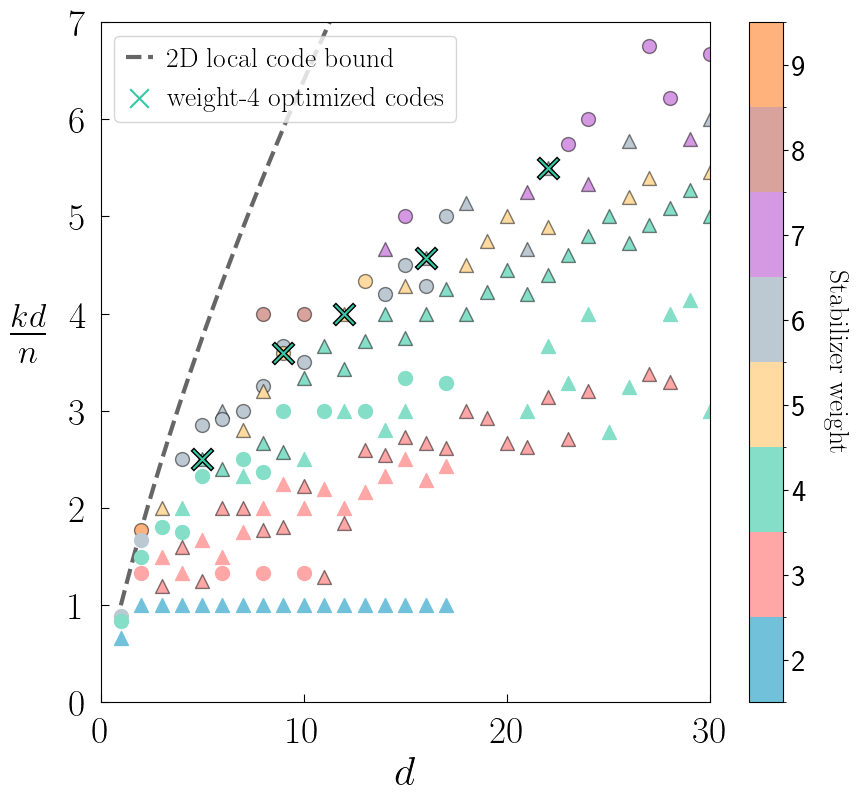

In [5]:
# use latex
plt.rcParams['text.usetex'] = True

# setup figure
fig,ax = plt.subplots()
fig.set_size_inches(9,8)

# set axis
ax.get_xaxis().set_tick_params(which='both', direction='in', labelsize=27, length=6,pad = 10)
ax.get_yaxis().set_tick_params(which='major', direction='in', labelsize=27, length=6,pad = 10)
ax.get_yaxis().set_tick_params(which='minor', direction='in', labelsize=27, length=3)
ax.set_xlabel(r'$d$', fontsize=30)
ax.set_ylabel(r'$\frac{kd}{n}$', fontsize=35,rotation=0,labelpad=30)

# Extract unique points and their corresponding stabilizer weight and isCellular and IsOn3Lines
X_points, Y_points = zip(*Unique_codes.keys())
W_points, C_points, ThreeLines_points = zip(*Unique_codes.values())

# Sort points by stabilizer weight in ascending order
sorted_indices = sorted(range(len(W_points)), key=lambda k: W_points[k], reverse=True)
X_sorted = [X_points[i] for i in sorted_indices]
Y_sorted = [Y_points[i] for i in sorted_indices]
W_sorted = [W_points[i] for i in sorted_indices]
C_sorted = [C_points[i] for i in sorted_indices]
ThreeLines_sorted = [ThreeLines_points[i] for i in sorted_indices]

# plot BPT bound
# https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.104.050503
w = 2 # range of stabilizer
dlist = np.linspace(1,20,100)
plt.plot(dlist, dlist * (2*np.sqrt(dlist-1)*w + w**2) / (dlist-1 + 2*np.sqrt(dlist-1)*w + w**2),'--',zorder=1, c='k',alpha = 0.6,linewidth = 3 ,label = r'$\textrm{2D local code bound}$')

# Plot all codes
for i in range(len(X_sorted)):
    if ThreeLines_sorted[i]:
        scatter = plt.scatter(X_sorted[i], Y_sorted[i], marker = ['o','^'][C_sorted[i]] , c = W_sorted[i], cmap=cmap, norm=norm, s=100,edgecolor=(0, 0, 0, 0.5), linewidth=1)  # Using jet colormap
    else:
        scatter = plt.scatter(X_sorted[i], Y_sorted[i], marker = ['o','^'][C_sorted[i]] , c = W_sorted[i], cmap=cmap, norm=norm, s=100)  # Using jet colormap

# Add the colorbar
cbar = plt.colorbar(scatter, ticks=midpoints)
cbar.set_ticklabels(np.arange(2, 10))
cbar.ax.tick_params(labelsize=22)
cbar.set_label(r'$\textrm{Stabilizer weight}$',fontsize = 20,labelpad=30,y=0.5,rotation = -90)

# Plot the optimized cellular automaton codes
plt.scatter([5,9,12,16,22],[2.5,18/5,24/6,32/7,44/8],marker = 'x',lw=3.5, color='black',s=220)
plt.scatter([5,9,12,16,22],[2.5,18/5,24/6,32/7,44/8],marker = 'x',lw=1.5, color=rgcolor[2],s=180,label=r'$\textrm{weight-4 optimized codes}$')

plt.xlim(0,30)

plt.legend(loc = 'upper left', prop={'size': 20},handlelength=1, handletextpad=0.5)

plt.tight_layout()

plt.ylim((0,7))

plt.savefig('Figure 1a.pdf')